# PVGIS Global Irradiance Map

#### Import Project Scripts

In [1]:
from scripts.create_lat_lon import create_gdf
from scripts.utils.geoprocessing_utils import square_grid
from scripts.utils.geodata_download import create_gisco_gdf
from scripts.utils.plot_points_and_polygons import plot_points_and_ine_municipalities, plot_points_and_countries

#### Import libraries

In [2]:
import os
import folium
import geopandas as gpd
from matplotlib import pyplot as plt

#### Localhost DB Connection

In [3]:
from scripts.db_clickhouse.clickhouse_management import conn_clickhouse
client = conn_clickhouse()

#### Set preferences

In [4]:
xmin = -3.8
ymin = 40.3
xmax = -3.5
ymax = 40.6

srid = 4326

#### Create a grid of points by bounding box

In [5]:
points_gdf = create_gdf(xmin, ymin, xmax, ymax, srid)
points_gdf.head()

,lat,lon,geometry
0,40.29,-3.80,POINT (-3.80000 40.29000)
1,40.29,-3.75,POINT (-3.75000 40.29000)
2,40.29,-3.70,POINT (-3.70000 40.29000)
3,40.29,-3.65,POINT (-3.65000 40.29000)
4,40.29,-3.60,POINT (-3.60000 40.29000)


#### Create a square grid with side and point center

In [6]:
grid_gdf = square_grid(points_gdf, 0.05)
grid_gdf.head()

,lat,lon,geometry
0,40.29,-3.80,"POLYGON ((-3.77500 40.26500, -3.77500 40.31500..."
1,40.29,-3.75,"POLYGON ((-3.72500 40.26500, -3.72500 40.31500..."
2,40.29,-3.70,"POLYGON ((-3.67500 40.26500, -3.67500 40.31500..."
3,40.29,-3.65,"POLYGON ((-3.62500 40.26500, -3.62500 40.31500..."
4,40.29,-3.60,"POLYGON ((-3.57500 40.26500, -3.57500 40.31500..."


#### Plot grid of points

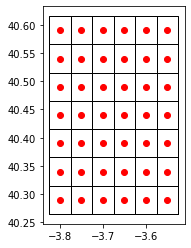

In [7]:
f, ax = plt.subplots(1)
grid_gdf.plot(ax=ax, color='white', edgecolor='black')
points_gdf.plot(ax=ax, color='red')
plt.show()

#### Calculate Anual Global Irradiance 

In [8]:
query = " \
        SELECT latitude, longitude, toYear(time) AS date, SUM(global_irradiance) AS golbal_irradiance \
        FROM seriescalc WHERE toYear(time) = 2016 \
        GROUP BY latitude, longitude, toYear(time) \
        "

gi_2016_df = client.query_dataframe(query)

gi_2016_df.head()

,latitude,longitude,date,golbal_irradiance
0,40.44,-3.75,2016,1684567.97
1,40.39,-3.65,2016,1686839.95
2,40.44,-3.60,2016,1687809.85
3,40.44,-3.55,2016,1687803.65
4,40.59,-3.70,2016,1684514.35


#### Merge Polygons and GIobal Irradiance by latitude and longitude

In [9]:
grid_gi_2016 = grid_gdf.merge(gi_2016_df, left_on=['lat','lon'], right_on=['latitude','longitude'])
del grid_gi_2016['lat']
del grid_gi_2016['lon']

grid_gi_2016.head()

,geometry,latitude,longitude,date,golbal_irradiance
0,"POLYGON ((-3.77500 40.26500, -3.77500 40.31500...",40.29,-3.80,2016,1665134.17
1,"POLYGON ((-3.72500 40.26500, -3.72500 40.31500...",40.29,-3.75,2016,1665123.24
2,"POLYGON ((-3.67500 40.26500, -3.67500 40.31500...",40.29,-3.70,2016,1665121.51
3,"POLYGON ((-3.62500 40.26500, -3.62500 40.31500...",40.29,-3.65,2016,1655846.20
4,"POLYGON ((-3.57500 40.26500, -3.57500 40.31500...",40.29,-3.60,2016,1650151.73


#### Choropleth maps

In [11]:
# Create an ID
grid_gi_2016["id"] = grid_gi_2016.index + 1
grid_gi_2016.head()

# Set Geo Data
grid_gi_2016_geo = grid_gi_2016.to_json() # geojson format

# create a plain world map
x0 = (xmin + xmax) / 2
y0 = (ymin + ymax) / 2
m = folium.Map(location=[y0, x0], zoom_start=10, tiles='CartoDB positron')

# generate choropleth map 
folium.Choropleth(
    geo_data=grid_gi_2016_geo,
    name="choropleth",
    data=grid_gi_2016,
    columns=["id", "golbal_irradiance"],
    key_on="feature.properties.id",
    fill_color="OrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Global Irradiance (W/m2)",
).add_to(m)

folium.LayerControl().add_to(m)

# display map
m